<h1>Статистический анализ данных о пользователях популярного сервиса аренды самокатов GoFast, а также об их поездках</h1>

<h2>Описание проекта</h2>

Заказчиком переданы необработанные данные из нескольких таблиц сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо корректно обработать полученные данные и на их основе исследовать и визуализировать интересующие заказчика показатели, а также подсчитать выручку.

<h2>Цель проекта</h2>

Цель проекта - это анализ данных сервиса аренды самокатов GoFast, а также проверка некоторых гипотез, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.

Сервисом можно пользоваться:

<ol>
    <li>без подписки:
    <ul>
    <li>абонентская плата отсутствует;</li>
    <li>стоимость старта (начала поездки) — 50 рублей;</li>
    <li>стоимость старта (начала поездки)</li>
    </ul>
    </li>
    <li>с подпиской Ultra:
    <ul>
    <li>абонентская плата — 199 рублей в месяц;</li>
    <li>стоимость одной минуты поездки — 6 рублей;</li>
    <li>стоимость старта — бесплатно.</li>
    </ul>
    </li>
</ol>

<h2>План работы</h2>
<ol>
    <li> Загрузка данных из имеющихся трёх таблиц</li>
    <li> Предобработка данных (корректировка, удаление пустых значений, приведение к корректному типу данных)</li>
    <li> Исследовательский анализ интересующих заказчика данных с построением графиков, гистограмм</li>
    <li> Подсчёт выручки</li>
    <li> Проверка озвученных заказчиком гипотез на основе исследовательского анализа данных</li>
</ol>

In [44]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import seaborn as sns

### Шаг 1. Загрузка данных

In [45]:
# считываем данные из CSV-файлы с данными
users_go = pd.read_csv('users_go.csv') 
rides_go = pd.read_csv('rides_go.csv') 
subscriptions_go = pd.read_csv('subscriptions_go.csv') 

           user_id          age
count  1565.000000  1565.000000
mean    762.633866    24.922045
std     443.260155     4.553496
min       1.000000    12.000000
25%     378.000000    22.000000
50%     762.000000    25.000000
75%    1146.000000    28.000000
max    1534.000000    43.000000


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


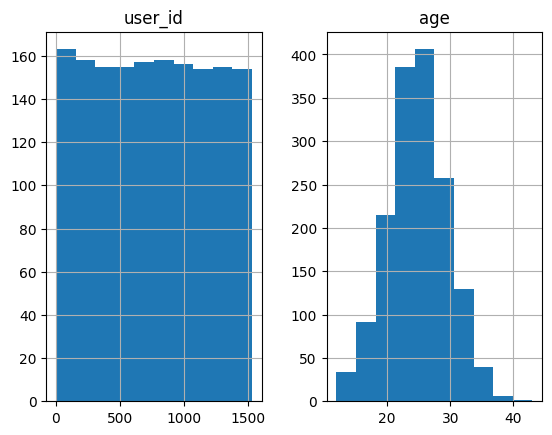

In [46]:
# изучим датафрейм 'users_go' 
print(users_go.describe())
users_go.hist()
users_go.head()

Датафрейм не имеет выбросов. Из гистограммы можно сделать вывод что присутствуют дубликаты идентификаторов в столбце ‘user_id’.

            user_id      distance      duration
count  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659976     17.805011
std      434.734317   1116.831209      6.091051
min        1.000000      0.855683      0.500000
25%      487.000000   2543.226360     13.597563
50%      889.000000   3133.609994     17.678395
75%     1213.250000   3776.222735     21.724800
max     1534.000000   7211.007745     40.823963


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


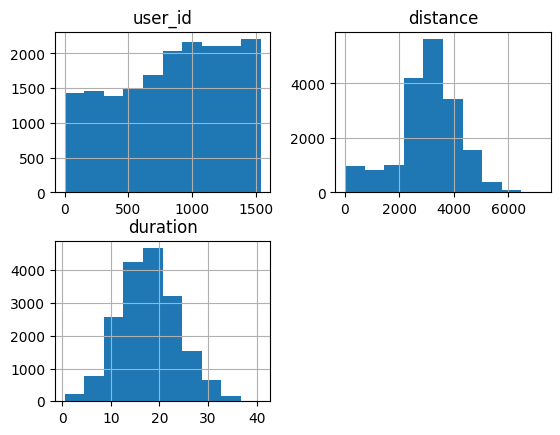

In [47]:
# Изучение датафрейма 'rides_go' 
print(rides_go.describe())
rides_go.hist() 
rides_go.head()

На основании полученных гистограмм можно сделать вывод о возможном наличии выбросов в столбцах ‘distance’ и ‘duration’.

In [48]:
# Изучение датафрейма 'subscriptions_go' 
print(subscriptions_go.info())
subscriptions_go.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### Шаг 2. Предобработка данных

In [49]:
# в столбце 'subscription_type' может быть всего два значения. 
# Существует ли подписка у пользователя либо не существует. Переведём значения данного столбца в тип bool
users_go.loc[users_go['subscription_type'] == 'ultra', 'subscription_type'] = True 
users_go.loc[users_go['subscription_type'] == 'free', 'subscription_type'] = False
users_go['subscription_type'] = users_go['subscription_type'].astype('bool')
subscriptions_go.loc[subscriptions_go['subscription_type'] == 'ultra', 'subscription_type'] = True
subscriptions_go.loc[subscriptions_go['subscription_type'] == 'free', 'subscription_type'] = False
subscriptions_go['subscription_type'] = subscriptions_go['subscription_type'].astype('bool')

# корректируем столбец 'date' в датафейме 'rides_go'
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [50]:
# добавим столбец с номером месяца на основе столбца date
rides_go['month'] = pd.DatetimeIndex(rides_go['date']).month

In [51]:
# проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют.
# cначала датафрейм с пользователями мобильного приложения
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В датафрейме users_go пропущенных значений не найдено

In [52]:
# затем в датафрейме с поездками
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

В датафрейме rides_go пропущенных значений не найдено

In [53]:
# и затем в датафрейме с типами подписки
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В датафрейме subscriptions_go пропущенных значений не найдено

In [54]:
# далее обработаем дубликаты если они есть
users_go.duplicated().sum()

31

В датафрейме users_go найден 31 дубликат. Удалим их

In [55]:
users_go.drop_duplicates(inplace=True)
users_go.duplicated().sum()

0

In [56]:
# далее обработаем дубликаты если они есть
rides_go.duplicated().sum()

0

Пропущенных значений в датафреймах не найдено.Удалены дубликаты в датафрейме с пользователями. 
Добавлен столбец с номером месяца.

### Шаг 3. Исследовательский анализ данных

Опишим и визуализируем общую информацию о пользователях и поездках:

Начнём с частоты встречаемости городов

In [57]:
count_users_by_city = users_go['city'].value_counts()
count_users_by_city2 = users_go['city'].value_counts()

In [58]:
# вычислим долю каждого города в общем нвборе данных датафрейма с пользователями
count_users_by_city['rate'] = round(users_go['city'].value_counts() / count_users_by_city.sum(), 6)
count_users_by_city['rate']

Пятигорск         0.142764
Екатеринбург      0.132986
Ростов-на-Дону    0.129074
Краснодар         0.125815
Сочи              0.123207
Омск              0.119296
Тюмень            0.117340
Москва            0.109518
Name: city, dtype: float64

Визуализируем полученные данные о наиболее и наименее представленных городах

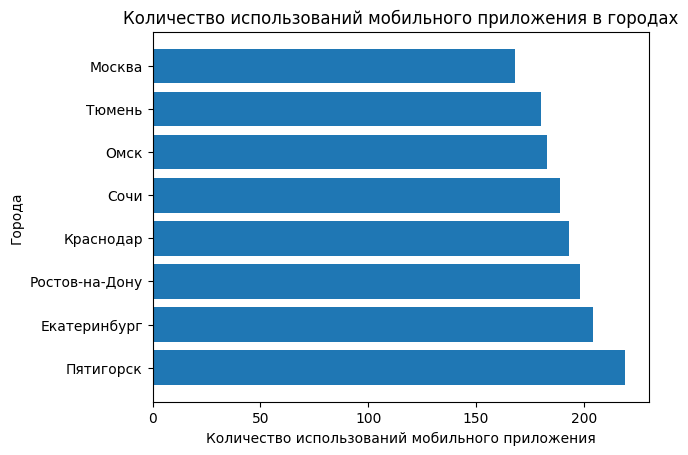

In [59]:
plt.barh(
       count_users_by_city2.index,
       count_users_by_city['rate'].values * count_users_by_city.sum()
    )
plt.gca().set(xlabel='Количество использований мобильного приложения', ylabel='Города')
plt.title('Количество использований мобильного приложения в городах')
plt.show()

Далее найдем соотношение пользователей с подпиской и без подписки

In [60]:
def is_subscription(subscription_type):
    for row in users_go['subscription_type']:
        if subscription_type == True:
            return 'Есть подписка'
        if subscription_type == False:
            return 'Нет подписки'
users_go['is_subscription'] = users_go['subscription_type'].apply(is_subscription)
count_sub = users_go['subscription_type'].value_counts()
count_sub

False    835
True     699
Name: subscription_type, dtype: int64

Визуализируем полученные данные о наличии подписки

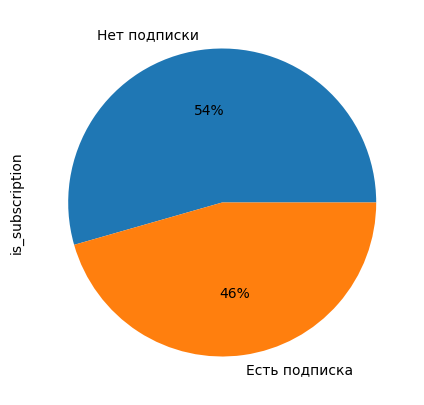

In [61]:
users_go['is_subscription'].value_counts().plot(
    kind = 'pie', 
    y = count_sub, 
    autopct = '%1.0f%%', 
    figsize=(5,5));

Выше представлено процентное соотношение пользователей мобильного приложения с подпиской и без подписки

Опишем и визуализируем информацию по возрасту пользователей.

Название столбца: age


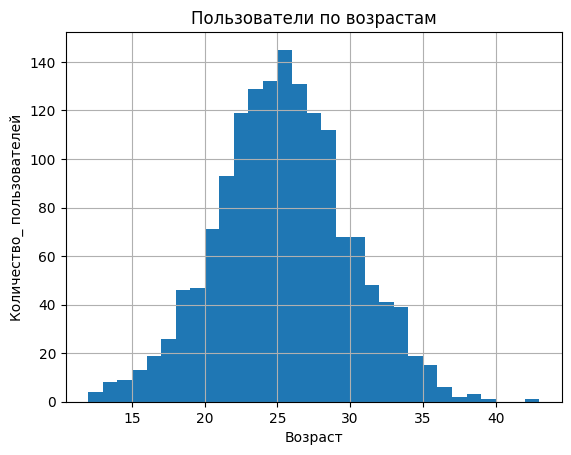

Описание датафрейма:
count    1534.0
mean       25.0
std         5.0
min        12.0
25%        22.0
50%        25.0
75%        28.0
max        43.0
Name: age, dtype: float64


In [62]:
print('Название столбца:', users_go.columns[2])
users_go['age'].hist(bins=users_go['age'].max()-users_go['age'].min())
plt.gca().set(xlabel='Возраст', ylabel='Количество_ пользователей')
plt.title('Пользователи по возрастам')
plt.show()
print('Описание датафрейма:')
print(users_go['age'].describe().round(0))

Затем выведем самых сташих пользователей.

Возраст пользователей мобильного приложения аренды самокатов от 12 до 43 лет. Присутствует нормальное распределение. Самые многочисленные пользователи имеют возраст 25 лет. Этот же возраст является медианным.

Опишем и визуализируем информацию по расстоянию, которое пользователь преодолел за одну поездку

Название столбца: distance


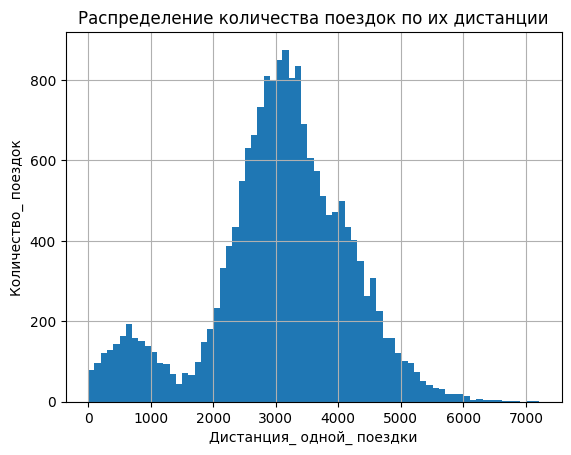

Описание датафрейма:
count    18068.0
mean      3071.0
std       1117.0
min          1.0
25%       2543.0
50%       3134.0
75%       3776.0
max       7211.0
Name: distance, dtype: float64


In [63]:
print('Название столбца:', rides_go.columns[1])
rides_go['distance'].hist(bins=int((rides_go['distance'].max()-rides_go['distance'].min()) / 100))
plt.gca().set(xlabel='Дистанция_ одной_ поездки', ylabel='Количество_ поездок')
plt.title('Распределение количества поездок по их дистанции')
plt.show()
print('Описание датафрейма:')
print(rides_go['distance'].describe().round(0))

Одна поездка по дистанции составляет от 1 до 7211 метров. Медиана всех значений равна 3134 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены.

Опишем и визуализируем информацию по продолжительности поездок

Название столбца: duration


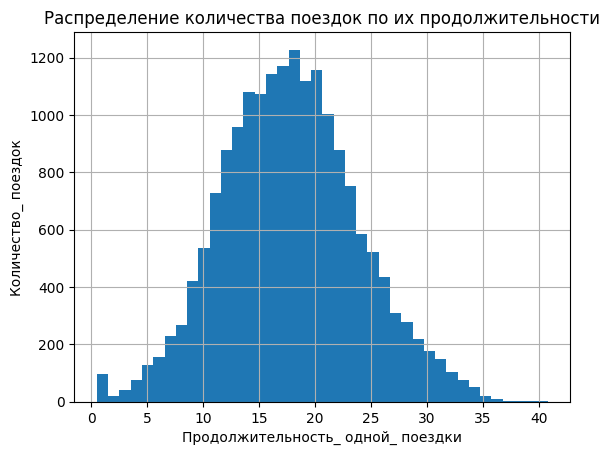

Описание датафрейма:
count    18068.0
mean        18.0
std          6.0
min          0.0
25%         14.0
50%         18.0
75%         22.0
max         41.0
Name: duration, dtype: float64


In [64]:
print('Название столбца:', rides_go.columns[2])
rides_go['duration'].hist(bins=int((rides_go['duration'].max()-rides_go['duration'].min())))
plt.gca().set(xlabel='Продолжительность_ одной_ поездки', ylabel='Количество_ поездок')
plt.title('Распределение количества поездок по их продолжительности')
plt.show()
print('Описание датафрейма:')
print(rides_go['duration'].describe().round(0))

Продолжительность поездок составляет от 0 до 41 минуты. Распределение является нормальным. 18 минут это наиболее частая продолжительность поездки. Она является и медианным значением.

### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм методом merge()

In [65]:
total_go = users_go.merge(rides_go, on='user_id').merge(subscriptions_go, on='subscription_type')

In [66]:
total_go.head()

,user_id,name,age,city,subscription_type,is_subscription,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,True,Есть подписка,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,True,Есть подписка,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,True,Есть подписка,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,True,Есть подписка,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,True,Есть подписка,4028.687306,26.265803,2021-08-28,8,6,0,199


In [67]:
print("Количество поездок в rides_go", rides_go['user_id'].count())
print("Количество поездок в total_go", total_go['user_id'].count())
print()
print("Количество пользователей в users_go", len(users_go['user_id'].unique()))
print("Количество пользователей в total_go", len(total_go['user_id'].unique()))

Количество поездок в rides_go 18068
Количество поездок в total_go 18068

Количество пользователей в users_go 1534
Количество пользователей в total_go 1534


Полученные датафреймы не содержали пропусков. Количество записей в них соответствует количеству в итоговом датафрейме

Создадим два датафрейма с пользователями, имеющими подписку и без неё

In [68]:
# Датафрейм данных с пользователями с подпиской
ultra_go = total_go.loc[total_go['subscription_type'] == True]
# Датафрейм данных с пользователями без подписки
free_go = total_go.loc[total_go['subscription_type'] == False]

In [69]:
ultra_go

,user_id,name,age,city,subscription_type,is_subscription,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,True,Есть подписка,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,True,Есть подписка,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,True,Есть подписка,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,True,Есть подписка,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,True,Есть подписка,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,True,Есть подписка,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,True,Есть подписка,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,True,Есть подписка,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,True,Есть подписка,4707.845501,15.839579,2021-10-17,10,6,0,199


In [70]:
free_go

,user_id,name,age,city,subscription_type,is_subscription,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,False,Нет подписки,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,False,Нет подписки,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,False,Нет подписки,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,False,Нет подписки,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,False,Нет подписки,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,False,Нет подписки,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,False,Нет подписки,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,False,Нет подписки,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,False,Нет подписки,2902.308661,16.674362,2021-11-27,11,8,50,0


Визуализируем информацию о расстоянии для пользователей мобильного приложения, не имеющих подписку

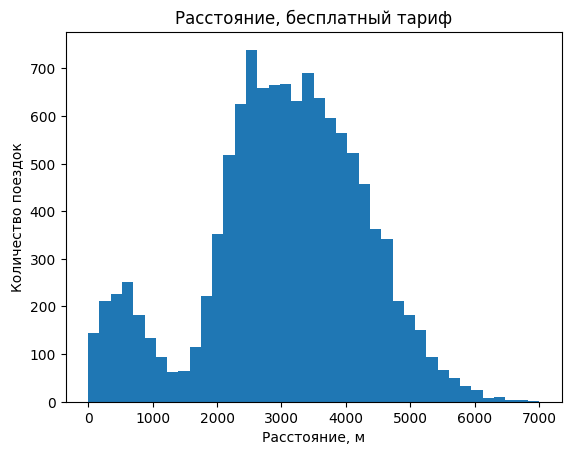

<Figure size 2000x2000 with 0 Axes>

In [71]:
plt.hist(free_go['distance'], bins=40, range = (0, 7000))
plt.title('Расстояние, бесплатный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

Визуализируем информацию о времени для пользователей мобильного приложения, не имеющих подписку

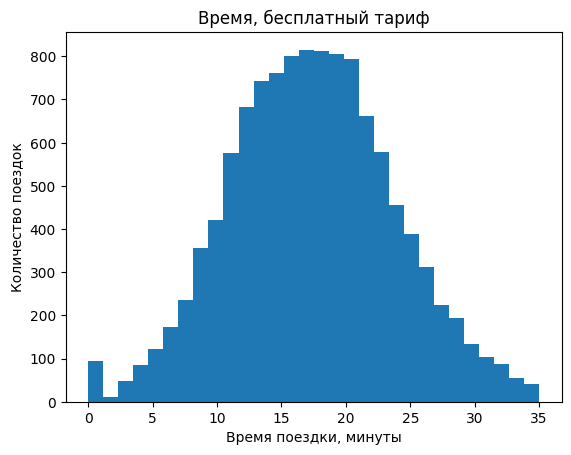

<Figure size 2000x2000 with 0 Axes>

In [72]:
plt.hist(free_go['duration'], bins=30, range = (0, 35))
plt.title('Время, бесплатный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

Визуализируем информацию о расстоянии для пользователей мобильного приложения, имеющих подписку

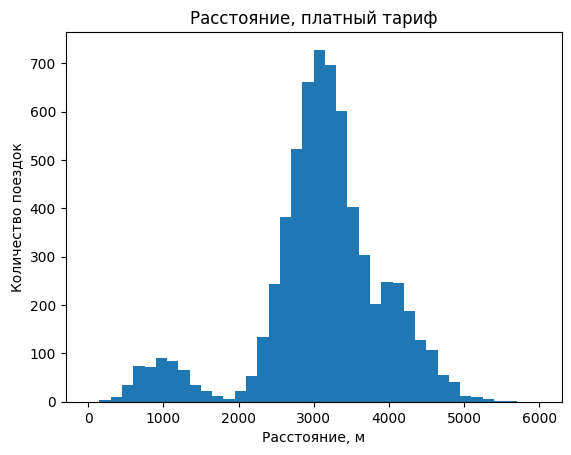

<Figure size 2000x2000 with 0 Axes>

In [73]:
plt.hist(ultra_go['distance'], bins=40, range = (0, 6000))
plt.title('Расстояние, платный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

Визуализируем информацию о времени для пользователей мобильного приложения, имеющих подписку

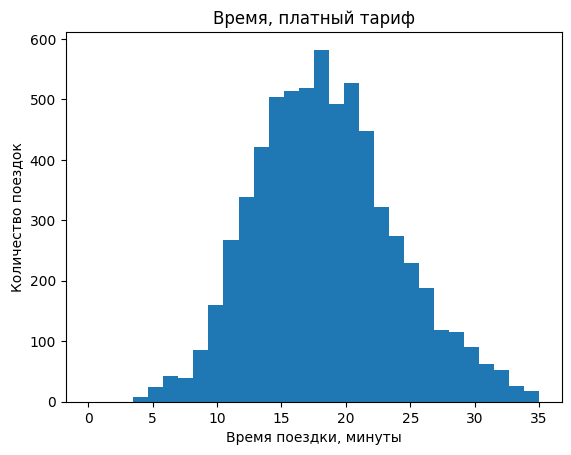

<Figure size 2000x2000 with 0 Axes>

In [74]:
plt.hist(ultra_go['duration'], bins=30, range = (0, 35))
plt.title('Время, платный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

На основании полученных гистограмм можно сделать вывод что время поездки для пользователей мобильного приложения, не имеющих подписку, составляет от 10 до 30 минут, а расстояние поездки составляет от 2 до 5 км. Время поездки для пользователей мобильного приложения, не имеющих подписку, составляет от 15 до 25 минут, а расстояние поездки составляет от 2 до 3 км.

Можно сделать вывод, что пользователи, не имеющие подписку, в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи у которых есть подписка.

### Шаг 5. Подсчёт выручки

Найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [75]:
total_go['duration'] = np.ceil(total_go['duration'])

In [76]:
total_data = pd.pivot_table(total_go,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min})

In [77]:
#в сводной таблице создадим столбец с количеством поездок
total_data.rename(columns = {'name' : 'count_tips'}, inplace = True)

In [78]:
total_data.sort_values(by='month')

distance  duration  count_tips  subscription_type
month user_id                                                       
1     1         7027.511294      42.0           2               True
      1061     12637.249630      43.0           3              False
      1063      3276.362299      10.0           1              False
      1064      5297.324649      15.0           1              False
      1065     14547.099333      99.0           4              False
...                     ...       ...         ...                ...
12    618       5269.450142      33.0           2               True
      619       2955.251037      17.0           1               True
      620       3972.842520      14.0           1               True
      600       3698.618505      14.0           1               True
      1534      2371.711192      16.0           1              False

[11331 rows x 4 columns]

 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [79]:
def revenue(row):
    if row['subscription_type'] == True:
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == False:
        return 8 * row['duration'] + 50 * row['count_tips']
    else:
        return 'Not such sub'

In [80]:
total_data['revenue_per_month'] = total_data.apply(revenue, axis=1)

In [81]:
total_data['revenue_per_month'].head(20)

month  user_id
1      1          451.0
       3          277.0
       5          277.0
       7          367.0
       12         397.0
       13         451.0
       14         409.0
       15         433.0
       20         373.0
       22         277.0
       25         301.0
       26         367.0
       30         349.0
       32         349.0
       35         541.0
       42         337.0
       43         487.0
       44         313.0
       45         361.0
       46         319.0
Name: revenue_per_month, dtype: float64

### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

<h5>Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

Нулевая и альтернативная гипотезы:
<br>Гипотеза Н0: Средняя продолжительность поездок с подпиской ‘ultra’ и ‘free’ равна.
<br>Гипотеза Н1: Средняя продолжительность поездок с подпиской ‘ultra’ больше чем средняя продолжительность поездок без подписки

In [82]:
results = st.ttest_ind(ultra_go['duration'], free_go['duration'],  alternative = 'greater')
print(results.pvalue)
if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

1.2804098316645613e-34
Отвергаем нулевую гипотезу


Не получилось отвергнуть гипотезу о том, что средняя продолжительность поездок с подпиской ‘ultra’ равна (или больше), чем с подпиской ‘free’.

<h5>Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Нулевая и альтернативная гипотезы:
<br>Гипотеза Н0: Среднее расстояние поездок с использованием подписки ‘ultra’ меньше или равно оптимальному расстоянию в 3130 метров.
<br>Гипотеза Н1: Среднее расстояние поездок с использованием подписки ‘ultra’ более 3130 метров.

In [83]:
results = st.ttest_1samp(ultra_go['distance'], 3130, alternative='greater')
print(results.pvalue)
if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

0.9195368847849785
Не отвергаем нулевую гипотезу


Не получилось отвергнуть гипотезу о том, что среднее расстояние поездок с использованием подписки ‘ultra’ (меньше или) равно 3130 метров.

<h5>Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая и альтернативная гипотезы:
<br>Гипотеза Н0: Средняя выручка от поездок с подпиской и без подписки равны.
<br>Гипотеза Н1: Средняя выручка от поездок с использованием подписки ‘ultra’ выше, чем выручка без использования подписки

In [84]:
ultra_per_mnth = total_data.loc[total_data.subscription_type == True, 'revenue_per_month'] 
free_per_mnth = total_data.loc[total_data.subscription_type == False, 'revenue_per_month'] 
results = st.ttest_ind(ultra_per_mnth, 
                       free_per_mnth,
                       alternative='greater')
alpha = .05
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


Вывод: можно утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей без подписки

<h5>Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Сформулируем гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:
<br>H0 : μ1 = μ2
<br>H1 : μ1 != μ2
<br>где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()

<h2>Выводы</h2>
Изначально данные в предоставленных таблицах не содержали пропусков.
<br>Значительных выбросов и дубликатов также не обнаружено кроме тех которые были обнаружены в файле ‘users_go.csv’.

<h3>В ходе исследовательского анализа данных было выявлено:</h3>

* Пользователей без подпискм всего 835, что составляет 54% от общего количества и на 136 больше, чем с подпиской «ultra».
* Услугами сервиса аренды самокатов пользуются люди от 12 до 43 лет. Максимальное количество пользователей в возрасте 25 лет, этот же возраст является медианным.
* Максимальное количество поездок совершено в Пятигорске. Минимальное количество в поездок совершено в Москве.
* Одна поездка по дистанции составляет от 1 до 7211 метров. Медиана всех значений равна 3134 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены. 
* Продолжительность поездок составляет от 0 до 41 минуты. Распределение является нормальным. 18 минут это наиболее частая продолжительность поездки. Она является и медианным значением. 

<h3>В результате группировки данных выявлено:</h3>
    
* Поездок без подписки на 5068 больше, чем с использованием подписки ‘ultra’, и составляет 11568.
Возрастные показатели пользователей с разным типом подписки в целом схожи, за исключением максимального возраста, который на 5 лет больше у пользователей мобильного приложения, не имеющих подписку
* У поездок без подписки максимальное расстояние больше примерно на 1500 метров чем при поездках с подпиской ultra. У поездок без подписки минимальное расстояние на 243 метра меньше чем при поездках с подпиской ultra. Можно сделать вывод что при поездках без подписки расстояния более разнообразные.
Об этом же свидетельствует и стандартное отклонение, которое без использования подписки больше на 409 метров, чем при использовании подписки ‘ultra’. 
* Средняя дистанция без использования подписки короче. 
* Продолжительность поездок при не использовании подписки немного меньше по всем показателям, чем при использовании подписки ‘ultra’. В обоих случаях количество поездок относительно нормально распределено в зависимости от их продолжительности. Пик количества поездок приходится на 17-18 минут. 

Были рассмотрены сделанные заказчиком гипотезы:

* о том что средняя продолжительность поездок с подпиской ‘ultra’ больше чем средняя продолжительность поездок без подписки. Гипотеза подтверждена. Имеет смысл развивать направление подписки и вкладываться в её рекламу. 
* о том что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку меньше ли равно оптимальному расстоянию износа самоката, а именно 3130 метров. Гипотеза подтверждена. Пользователи с подпиской не проезжают больше расстояния, необходимого для оптимального износа самоката
* о том что будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Гипотеза подтверждена. Имеет смысл развивать направление подписки и вкладываться в её рекламу.